In [1]:
# Artificial stock market for master thesis
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
import math
import scipy.stats as scs
# matrix that randomly assigns -1,0,+1 
# We use this method in order to initialize which investors are out, long buying 
# or short selling
# investors , values, constants
degree = 600
N = 1000
investors = 1000
companies = 5
# adjacency matrix
G = nx.random_regular_graph(degree, N)
M = nx.adjacency_matrix(G)
connected = nx.is_connected(G)
print("Is the graph connected?", connected)
# make it an np array
M_array = M.todense()
m_ia = np.random.randint(low=-1, high=2, size=(investors,companies), dtype='l')
m_ia_t_1 = np.zeros_like(m_ia, dtype=np.int64)
# initialize the operation of the changing of the even between m_ia(t) and m_ia(t-1)
operation_ia = np.zeros_like(m_ia, dtype=np.int64)
# initialize the number of neighbored buyers, sellers and holders and total amount of buyers , sellers and holders
neighbour_buy =  np.zeros(m_ia.shape, dtype=np.float64)
neighbour_sell = np.zeros_like(neighbour_buy)
total_number_of_buyers = np.zeros((1, m_ia.shape[1]), dtype=np.int64)
total_number_of_sellers = np.zeros((1, m_ia.shape[1]), dtype=np.int64)
total_number_of_holders = np.zeros((1, m_ia.shape[1]), dtype=np.int64)

# either the disposition effect or the stop-loss effect
initial_company_price = [10,10,10,10,10]
company_stock_price = np.full(m_ia.shape[1],initial_company_price)
# use dataframe
price_df = pd.DataFrame(columns=['Time'] + ['Company_' + str(i) for i in range(m_ia.shape[1])])
row1 = {'Time': 0}
row1.update({'Company_' + str(i): initial_company_price[i]  for i in range(m_ia.shape[1])})
price_df = price_df.append(row1, ignore_index=True)
# price at time step at t0 and t-1
# np array 1 dimesional
# to not 0s of m_ia but to 1s and -1s
# if t < 1 then we randomize +-10% the 1s and -1s over 50
# or randomly entering and exiting the market
# do that for the entry price as well 0 is the agent is not in the market 
# absolute value to turn the -1s to 1s by multiplying with the absolute m_ia
initial_price = np.random.uniform(low=9.5, high=10.5, size=m_ia.shape)
entry_price = initial_price * np.abs(m_ia)
entry_price[m_ia == 0] = initial_price[m_ia == 0] 
company_stock_price_t_1 = np.zeros_like(company_stock_price)
demand_array = np.zeros_like(company_stock_price)
ind_prob_buy = np.zeros_like(m_ia, dtype=np.float64)
ind_prob_sell = np.zeros_like(m_ia, dtype=np.float64)
ind_prob_hold = np.zeros_like(m_ia, dtype=np.float64)
local_prob_buy = np.zeros_like(m_ia, dtype=np.float64)
local_prob_sell = np.zeros_like(m_ia, dtype=np.float64)
local_prob_hold = np.zeros_like(m_ia, dtype=np.float64)
global_prob_buy = np.zeros_like(m_ia, dtype=np.float64)
global_prob_sell = np.zeros_like(m_ia, dtype=np.float64)
global_prob_hold = np.zeros_like(m_ia, dtype=np.float64)
long_buying_prob = np.zeros_like(m_ia, dtype=np.float64)
short_selling_prob = np.zeros_like(m_ia, dtype=np.float64)
bias_to_buy = np.zeros_like(m_ia, dtype=np.float64)
bias_to_sell = np.zeros_like(m_ia, dtype=np.float64)
# demand here np array 1 dimesional
demand_of_company = np.zeros_like(company_stock_price)
# weight of how much investors are affected by local information
kappa = 0.75
# weight of how much investors are affected by global information
zeta = 0.25
# probability in favor of disposition effect
prob_disposition = 0.6
type_of_investor = np.random.choice([0, 1], size=investors, p=[1-prob_disposition, prob_disposition])
# initialize the expected return as a random value 
expected_return = np.random.uniform(low=0.01, high=0.1, size=(investors,companies))
total_number_of_buyers = np.sum(m_ia == 1, axis=0)
total_number_of_sellers  = np.sum(m_ia == -1, axis=0)
total_number_of_holders  = np.sum(m_ia == 0, axis=0)
#col_company_alpha = m_ia[:, company_alpha]
ones = np.ones((investors,companies))
neighbour_buy= np.divide(M_array*np.where(m_ia<1.,0,m_ia),M_array*ones)# if this does not work use np.where function
neighbour_sell = np.divide(M_array*abs(np.where(m_ia>-1,0,m_ia)),M_array*ones)
neighbour_hold = ones - neighbour_buy - neighbour_sell
lower_limit = 252
upper_limit = 784 

C:\Users\nicko\AppData\Local\Temp\ipykernel_88432\2725974956.py:15: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  M = nx.adjacency_matrix(G)


Is the graph connected? True


In [2]:
# time steps
# 1085 is the financial days from the start of the pandemic
time = range(1085)
# companies that performed different
# restaurant chain, hotel chain, video meetings, ordering food services, 
beta = [-0.2, -0.25, 0.1, 0.15, 0.0001]
SO = [1000000, 10000, 3000, 50000, 100000]
m_ia_t_1 = np.copy(m_ia)
index = 10
for t in time:          
    # get the rows
    print(f"############## TIME: ########### {++t}")
    for investor_i in range(m_ia.shape[0]):
        # get the columns
        for company_alpha in range(m_ia.shape[1]):
            ####### INSIDE THE MARKET LONG BUYING #######
            ###################################################################################################################################################
            ###################################################################################################################################################
            if(m_ia[investor_i, company_alpha] == 1):
                #print( "COMING IN FOR M_IA == 1")
                #print(f"investor {investor_i + 1} has entry price {entry_price[investor_i,company_alpha]}")
                # type of investor accoridng to stop-loss effect
                if type_of_investor[investor_i] == 0:
                    # they are losing at a lower constant
                    # if COVID is true
                    if(lower_limit < t < upper_limit):
                        # lim_SLI is basically just a multiplication of the expected returns
                        # same to the type of investor == 1
                        lim_SLI = expected_return[investor_i,company_alpha]*(1+beta[company_alpha]) # multiply with a value between 0 and or smaller to 1 to reduce     
                    else: 
                        lim_SLI = expected_return[investor_i,company_alpha]
                    # fix the variables and make sure the company stock price is a vector 
                    if(entry_price[investor_i,company_alpha] - company_stock_price[company_alpha] > lim_SLI*entry_price[investor_i,company_alpha]):
                        entry_price[investor_i,company_alpha] = 0
                        m_ia[investor_i,company_alpha] = 0 
                        #print("Here is m_ia of exiting condition" , m_ia)
                    elif (company_stock_price[company_alpha] - entry_price[investor_i,company_alpha] > 0.5*lim_SLI*entry_price[investor_i,company_alpha]):
                        entry_price[investor_i,company_alpha] = 0
                        m_ia[investor_i,company_alpha] = 0 
                        #print("here is exiting the long buying m_ia ", m_ia)
                # type of investor accoridng to disposition effect
                elif type_of_investor[investor_i] == 1:
                    if(lower_limit < t < upper_limit):            
                        Lambda  = expected_return[investor_i,company_alpha]*(1+beta[company_alpha])
                    else:
                        Lambda  = expected_return[investor_i,company_alpha]
                    if(entry_price[investor_i,company_alpha] - company_stock_price[company_alpha] > Lambda*entry_price[investor_i,company_alpha]):
                        entry_price[investor_i,company_alpha] = 0
                        m_ia[investor_i,company_alpha] = 0 
                        #print("here is exiting the long buying m_ia ", m_ia)
                        # it is interesting to record the operation matrix , better structure to do it here 
                    elif (company_stock_price[company_alpha] - entry_price[investor_i,company_alpha] > 2.25*Lambda*entry_price[investor_i,company_alpha]):
                        entry_price[investor_i,company_alpha] = 0
                        m_ia[investor_i,company_alpha] = 0 
                        #print("here is exiting the long buying m_ia ", m_ia)
                ####### INSIDE THE MARKET SHORT SELLING #######
                ###################################################################################################################################################
                ###################################################################################################################################################
            elif(m_ia[investor_i, company_alpha] == -1):
                #print( "COMING IN FOR M_IA == -1")
                #print(f"investor {investor_i + 1} has entry price {entry_price[investor_i,company_alpha]}")
                # type of investor either disposition effect or stop-loss effect
                if type_of_investor[investor_i] == 0:
                    if (lower_limit < t < upper_limit):
                        lim_SLI = expected_return[investor_i,company_alpha]*(1+beta[company_alpha])
                    else: 
                        lim_SLI = expected_return[investor_i,company_alpha]
                    if(entry_price[investor_i,company_alpha] - company_stock_price[company_alpha] > lim_SLI*entry_price[investor_i,company_alpha]):
                        entry_price[investor_i,company_alpha] = 0
                        m_ia[investor_i,company_alpha] = 0 
                    elif (company_stock_price[company_alpha] - entry_price[investor_i,company_alpha] > 0.5*lim_SLI*entry_price[investor_i,company_alpha]):
                        entry_price[investor_i,company_alpha] = 0
                        m_ia[investor_i,company_alpha] = 0 
                # type of investor accoridng to disposition effect
                elif type_of_investor[investor_i] == 1:
                    if(lower_limit < t < upper_limit):            
                        Lambda  = expected_return[investor_i,company_alpha]*(1+beta[company_alpha])
                    else:
                        Lambda  = expected_return[investor_i,company_alpha]  
                    if(entry_price[investor_i,company_alpha] - company_stock_price[company_alpha] > Lambda*entry_price[investor_i,company_alpha]):
                        entry_price[investor_i,company_alpha] = 0
                        m_ia[investor_i,company_alpha] = 0
                    elif (company_stock_price[company_alpha] - entry_price[investor_i,company_alpha] > 2.25*Lambda*entry_price[investor_i,company_alpha]):
                        entry_price[investor_i,company_alpha] = 0
                        m_ia[investor_i,company_alpha] = 0
                ####### OUTSIDE OF THE MARKET #######
                ###################################################################################################################################################
                ###################################################################################################################################################
            elif(m_ia[investor_i, company_alpha] == 0):
                #print( "COMING IN FOR M_IA == 0")
                # bias == 1 there is a bias for buying
                own_information = np.random.randint(0,2)
                bias = np.random.randint(0,2)
                gamma = np.random.uniform(low=0, high = 5)
                if own_information == 1 and bias == 1:
                    bias_to_buy[investor_i, company_alpha] = 2/3 * (1-np.exp(-gamma))
                elif own_information == 1 and bias == 0:
                    bias_to_sell[investor_i, company_alpha] = 2/3 * (1-np.exp(-gamma))
                else:
                    bias_to_buy[investor_i, company_alpha] = 0
                    bias_to_sell[investor_i, company_alpha] = 0
                # calculate the probabilities of individual, local, global information
                ind_prob_buy[investor_i, company_alpha] = 1/3 + bias_to_buy[investor_i, company_alpha] - 1/2*bias_to_sell[investor_i, company_alpha]
                ind_prob_sell[investor_i, company_alpha] = 1/3 - 1/2*bias_to_buy[investor_i, company_alpha] + 1/2*bias_to_sell[investor_i, company_alpha]
                ind_prob_hold[investor_i, company_alpha] = 1/3 - 1/2*bias_to_buy[investor_i, company_alpha] - 1/2*bias_to_sell[investor_i, company_alpha]
                #print("Independent probability ", ind_prob_buy)
                #print("here is the sum of investors according to adjacent matrix ",np.sum(M_array[:,investor_i]))
                #Neighbour_buy = np.divide(M*O_buy,M*ones)
                #Neighbour_sell = np.divide(M*O_sell,M*ones)
                local_prob_buy[investor_i, company_alpha] =  neighbour_buy[investor_i, company_alpha]
                local_prob_sell[investor_i, company_alpha] = neighbour_sell[investor_i, company_alpha]
                local_prob_hold[investor_i, company_alpha] = neighbour_hold[investor_i, company_alpha]
                global_prob_buy[investor_i, company_alpha] = total_number_of_buyers[company_alpha] / (total_number_of_buyers[company_alpha] + total_number_of_sellers[company_alpha] + total_number_of_holders[company_alpha])
                global_prob_sell[investor_i, company_alpha] = total_number_of_sellers[company_alpha] / (total_number_of_buyers[company_alpha] + total_number_of_sellers[company_alpha] + total_number_of_holders[company_alpha])
                global_prob_hold[investor_i, company_alpha] = total_number_of_holders[company_alpha] / (total_number_of_buyers[company_alpha] + total_number_of_sellers[company_alpha] + total_number_of_holders[company_alpha])
                #print("HERE IS GLOBAL PROBABILITY OF BUYING ", global_prob_buy[investor_i,company_alpha])
                long_buying_prob[investor_i, company_alpha] = (1 - kappa - zeta)*ind_prob_buy[investor_i, company_alpha] + kappa*neighbour_buy[investor_i, company_alpha] + zeta*global_prob_buy[investor_i, company_alpha]
                short_selling_prob[investor_i, company_alpha] = (1 - kappa - zeta)*ind_prob_sell[investor_i, company_alpha] + kappa*neighbour_sell[investor_i, company_alpha] + zeta*global_prob_sell[investor_i, company_alpha]
                #print("long buying probability", long_buying_prob[investor_i, company_alpha])
                #print("short selling probability", short_selling_prob[investor_i, company_alpha])
                # set the behaviour a little more in favor of disposition effect
                prob_disposition_of_entering = 0.6
                randomly_picked = np.random.choice([0, 1], size=1, p=[1-prob_disposition_of_entering, prob_disposition_of_entering])
                if ( randomly_picked < long_buying_prob[investor_i, company_alpha]):
                    entry_price[investor_i,company_alpha] = company_stock_price[company_alpha]
                    m_ia[investor_i,company_alpha] = 1
                elif(randomly_picked > 1 - short_selling_prob[investor_i, company_alpha]):
                    entry_price[investor_i,company_alpha] = company_stock_price[company_alpha]
                    m_ia[investor_i,company_alpha] = -1
    #print("HERE IS m_ia", m_ia)
    #print("the total number of buyers",total_number_of_buyers)            
    operation_ia = m_ia - m_ia_t_1
    #print("here is the operation_ia ", operation_ia)
    # calculating the number of total buyers sellers and holders for each company
    total_number_of_buyers = np.sum(operation_ia == 1, axis=0)
    total_number_of_sellers  = np.sum(operation_ia == -1, axis=0)
    total_number_of_holders  = np.sum(operation_ia == 0, axis=0)
    neighbour_buy = np.divide(M_array*np.where(operation_ia<1.,0,operation_ia),M_array*ones)# if this does not work use np.where function
    neighbour_sell = np.divide(M_array*abs(np.where(operation_ia>-1,0,operation_ia)),M_array*ones)
    neighbour_hold = ones - neighbour_buy - neighbour_sell
    company_stock_price_t_1 = company_stock_price
    demand_of_company =  (total_number_of_buyers - total_number_of_sellers) / (total_number_of_buyers + total_number_of_sellers +total_number_of_holders)
    log_returns = np.log(company_stock_price / company_stock_price_t_1)
            
    if(lower_limit < t < upper_limit):
        company_stock_price = company_stock_price_t_1*(1 + np.tanh(demand_of_company))*(1 + np.tanh(beta))
    else:
        company_stock_price = company_stock_price_t_1*(1 + np.tanh(demand_of_company))
    # market capitalization
    index_t_1 = index
    MC = company_stock_price * SO
    weight_alpha = MC / np.sum(MC)
    index = np.sum(weight_alpha*company_stock_price)
    r_index = np.log(index / index_t_1)
    
    # make row 2 and insert it in the dataframe
    row2 = {'Time': t+1, 'Company_0': company_stock_price[0], 'Company_1': company_stock_price[1], 'Company_2': company_stock_price[2], 'Company_3': company_stock_price[3], 'Company_4': company_stock_price[4], 'Returns of Index':r_index }
    price_df = price_df.append(row2, ignore_index=True)
    m_ia_t_1 = np.copy(m_ia)  
    print(total_number_of_buyers)
    print(total_number_of_sellers)
    print(total_number_of_holders)
    # set the index of time
price_df.set_index('Time', inplace=True)

############## TIME: ########### 0
[178 172 198 208 178]
[269 286 294 255 264]
[553 542 508 537 558]
############## TIME: ########### 1
[475 518 470 238 413]
[394 451 424 238 392]
[131  31 106 524 195]
############## TIME: ########### 2
[345 385 378 141 315]
[519 573 493 217 426]
[136  42 129 642 259]
############## TIME: ########### 3
[578 607 551 548 566]
[422 393 449 425 434]
[ 0  0  0 27  0]
############## TIME: ########### 4
[440 401 437 413 412]
[560 599 563 560 588]
[ 0  0  0 27  0]
############## TIME: ########### 5
[572 585 560 570 587]
[428 415 440 430 413]
[0 0 0 0 0]
############## TIME: ########### 6
[411 416 452 411 400]
[589 584 548 589 600]
[0 0 0 0 0]
############## TIME: ########### 7
[577 584 529 589 597]
[423 416 432 411 403]
[ 0  0 39  0  0]
############## TIME: ########### 8
[440 427 413 400 410]
[560 573 548 600 590]
[ 0  0 39  0  0]
############## TIME: ########### 9
[564 568 572 600 595]
[436 432 428 400 405]
[0 0 0 0 0]
############## TIME: ########### 10
[418

In [3]:


data = pd.DataFrame(price_df)
data.head(100)


,Company_0,Company_1,Company_2,Company_3,Company_4,Returns of Index
Time,,,,,,
0.0,10,10,10,10,10,NaN
1.0,9.092504,8.864913,9.042938,9.530346,9.142114,-0.092725
2.0,9.82739,9.457975,9.45862,9.530346,9.33407,0.069498
3.0,8.134475,7.700532,8.375649,8.807431,8.302223,-0.177981
4.0,9.393258,9.323742,9.227015,9.885315,9.391795,0.140857
...,...,...,...,...,...,...
95.0,2.837859,2.800223,2.651452,1.256831,2.00314,-0.178935
96.0,3.277008,3.31514,3.041027,1.576437,2.285689,0.143684
97.0,2.814775,2.873551,2.505369,1.217127,1.808254,-0.153835


In [4]:
def print_statistics(data):
    returns = data["Returns of Index"].dropna()
    print("RETURN SAMPLE STATISTICS")
    print("---------------------------------------------")
    print("Mean %9.6f" % np.mean(returns))
    print("Standard deviation %9.6f" % np.std(returns))
    print("Variance %9.6f" % np.var(returns))
    print("---------------------------------------------")
    print("Skewness %9.6f" % scs.skew(returns))
    print("---------------------------------------------")
    print("Kurtosis %9.6f" % scs.kurtosis(returns))
    print("---------------------------------------------")

In [5]:
print_statistics(data)

RETURN SAMPLE STATISTICS
---------------------------------------------
Mean  0.059519
Standard deviation  0.138161
Variance  0.019089
---------------------------------------------
Skewness -0.929141
---------------------------------------------
Kurtosis -0.656664
---------------------------------------------


Text(0, 0.5, 'Returns')

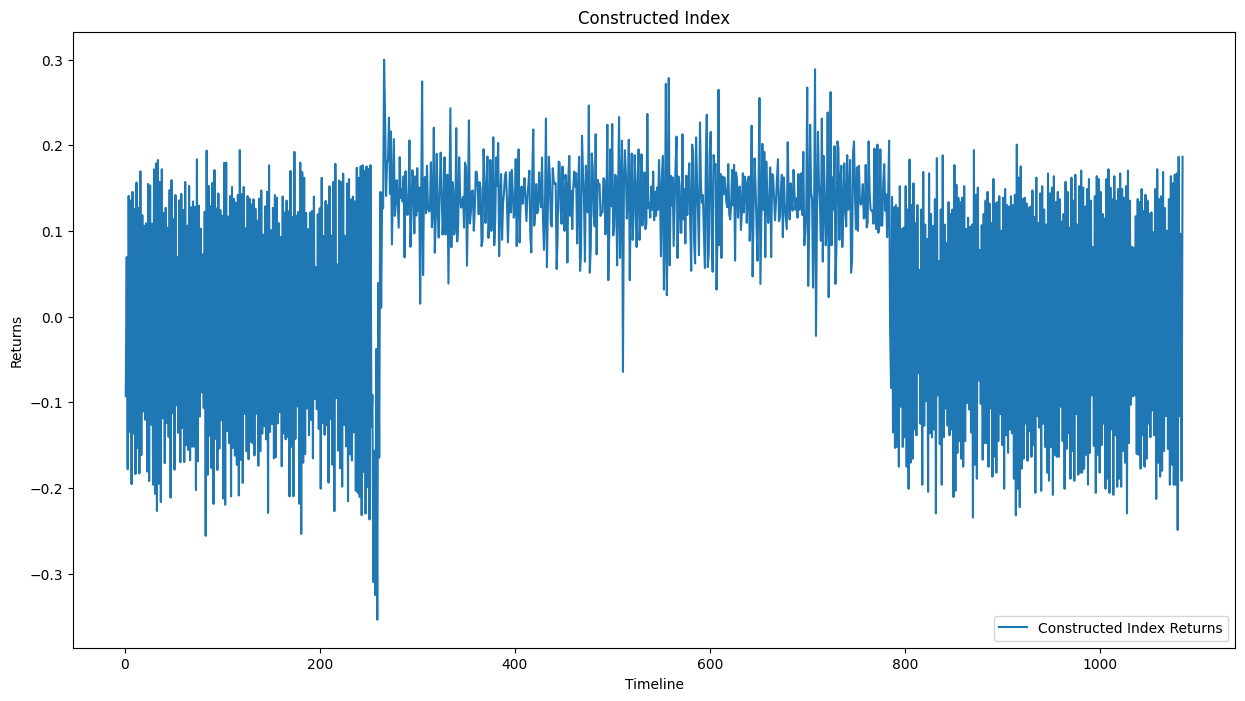

In [6]:
# Plotting the returns for OMXS30
plt.figure(figsize=(15, 8)) # size of figure
plt.title('Constructed Index') # title 
plt.plot(data["Returns of Index"]) # plot Close prices
plt.legend(["Constructed Index Returns"], loc='lower right')
plt.xlabel('Timeline') 
plt.ylabel('Returns')

0      -0.092725
1       0.069498
2      -0.177981
3       0.140857
4      -0.134369
          ...   
1080    0.186522
1081   -0.116038
1082    0.096807
1083   -0.191409
1084    0.186522
Name: Returns of Index, Length: 1085, dtype: float64
Optimization terminated successfully    (Exit mode 0)
            Current function value: -821.7791632800602
            Iterations: 7
            Function evaluations: 29
            Gradient evaluations: 3
                     Constant Mean - GARCH Model Results                      
Dep. Variable:       Returns of Index   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                821.779
Distribution:                  Normal   AIC:                          -1635.56
Method:            Maximum Likelihood   BIC:                          -1615.60
                                        No. Observations:                 1085

C:\Users\nicko\anaconda3\lib\site-packages\arch\univariate\base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.01909. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


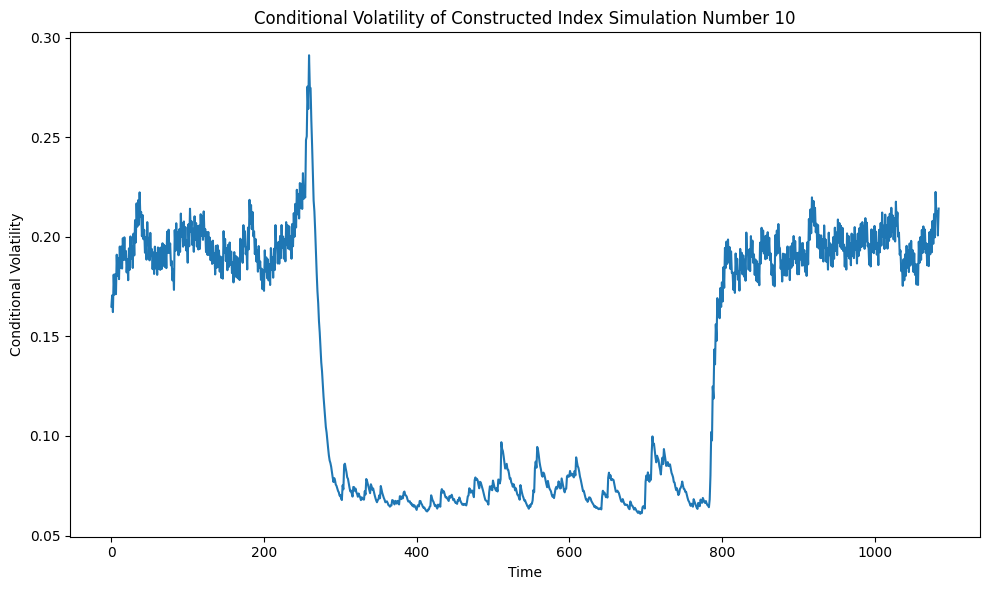

In [8]:
returns = data["Returns of Index"].dropna()
returns = returns.dropna()
returns.reset_index(drop=True, inplace=True)
print(returns)

GARCH = arch_model(returns, p=1, q=1, mean='constant', vol='GARCH', dist='normal')
model_fit = GARCH.fit(update_freq=4)

# Adjust figure size
fig, ax = plt.subplots(figsize=(10, 6))

# Plot conditional volatility with dates
model_fit.conditional_volatility.plot(ax=ax, title="Conditional Volatility of Constructed Index Simulation Number 9")
ax.set_ylabel('Conditional Volatility')
ax.set_xlabel('Time')
# Adjust spacing between subplots
plt.tight_layout()

print(model_fit.summary())

# Save the figure
plt.savefig('conditional_volatility.png')

# Show the plot
plt.show()
